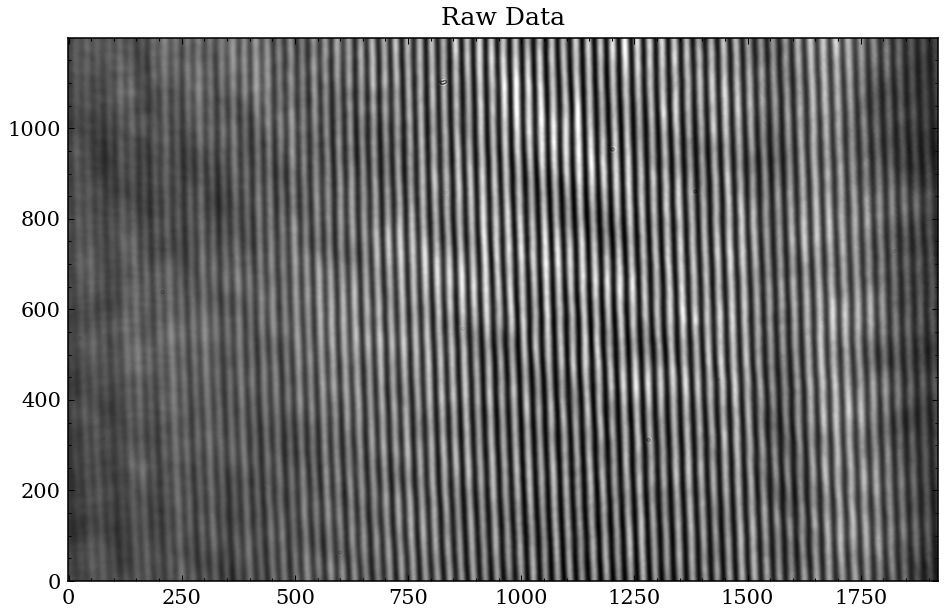

In [28]:
from common_imports import *
from parse_shot_diary import get_shot_diary, shot_string
%matplotlib inline

data_dir = '../Raw Data/20230811/interferometer/'
shot_number = 88

from interferometry import get_if_shot

# get data image and all applicable reference images for this shot
data, refs = get_if_shot(data_dir, shot_number)

plt.imshow(data)
plt.title('Raw Data')
plt.show()

### Equalize data

We care about the phase of the fringes, not their amplitude, so it's useful to first equalize the interferogram to remove any influence of probe intensity on the spectrum.

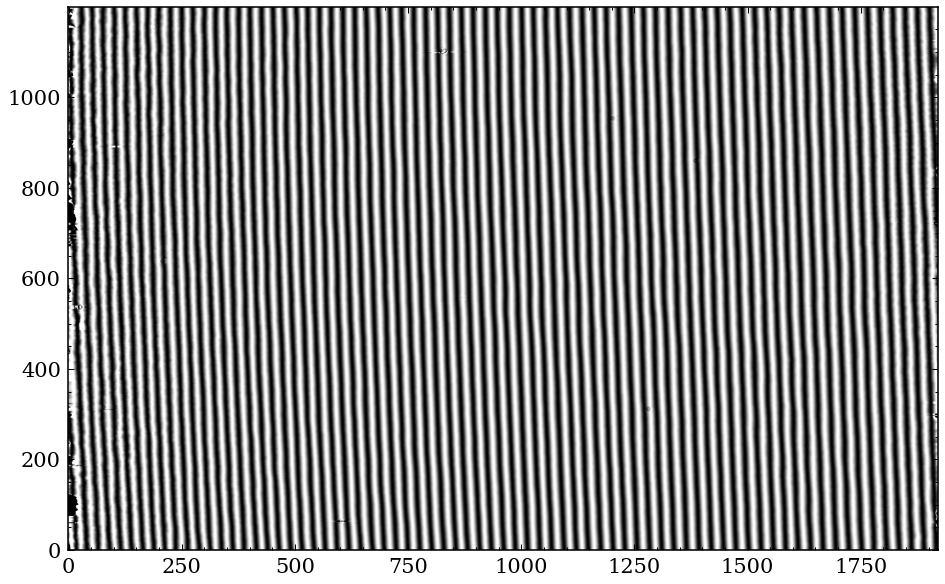

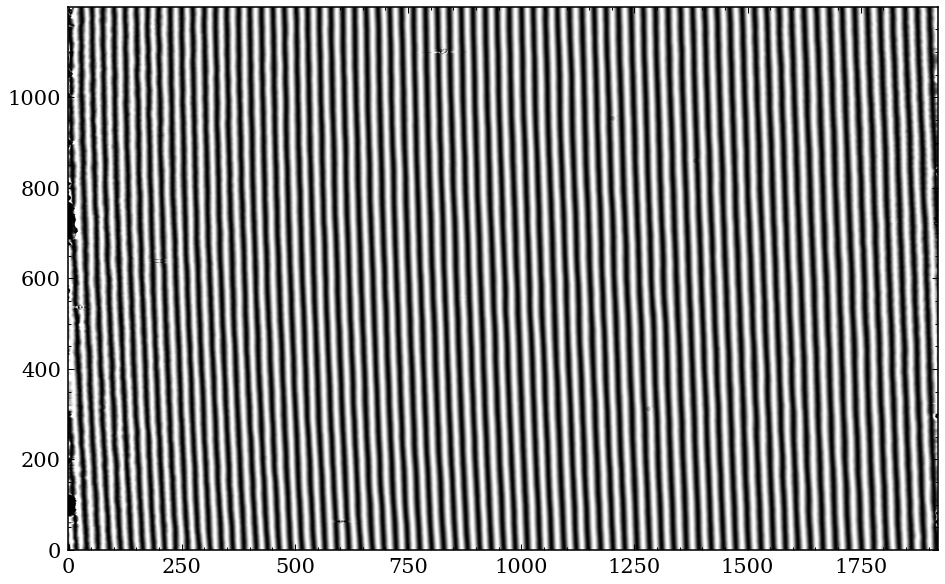

In [29]:
from interferometry import equalize

data_eq = equalize(data)
refs_eq =  [equalize(ref) for ref in refs]
plt.imshow(data_eq)
plt.show()
plt.imshow(refs_eq[0])

### Calculate phase

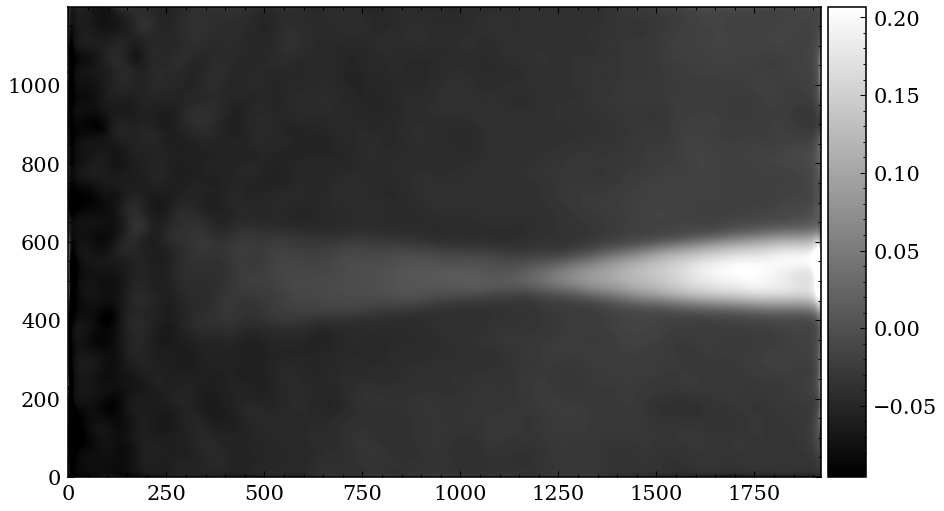

In [11]:
from interferometry import get_phase

pha, valid = get_phase(data_eq, refs_eq, bw_x = 10)
h, w = pha.shape

vmin = pha[valid].min()
vmax = pha[valid].max()
colorbar(plt.imshow(pha, vmin=vmin, vmax=vmax))


Center = 517.3, Sigma = 38.4, Offset = -0.00


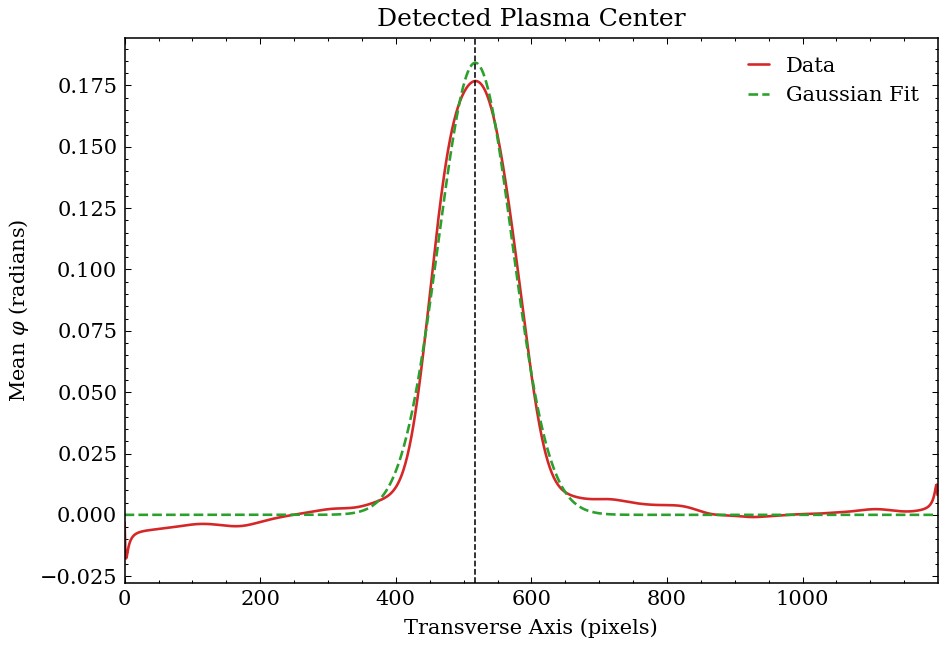

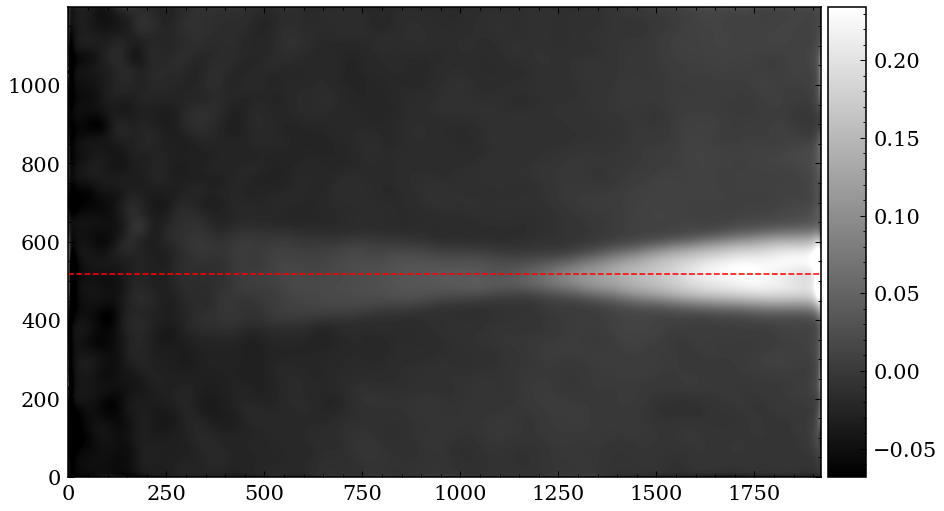

In [21]:
from interferometry import detect_center
    
center, offset = detect_center(pha, plot = True)
pha -= offset

colorbar(plt.imshow(pha, vmin=pha[valid].min(), vmax=pha[valid].max() ))
plt.gca().axhline(center, ls='--', color='r', lw=.75)
plt.show()

Center = 517.3, Sigma = 38.4, Offset = -0.00
Using memory-cached basis sets
Using memory-cached basis sets


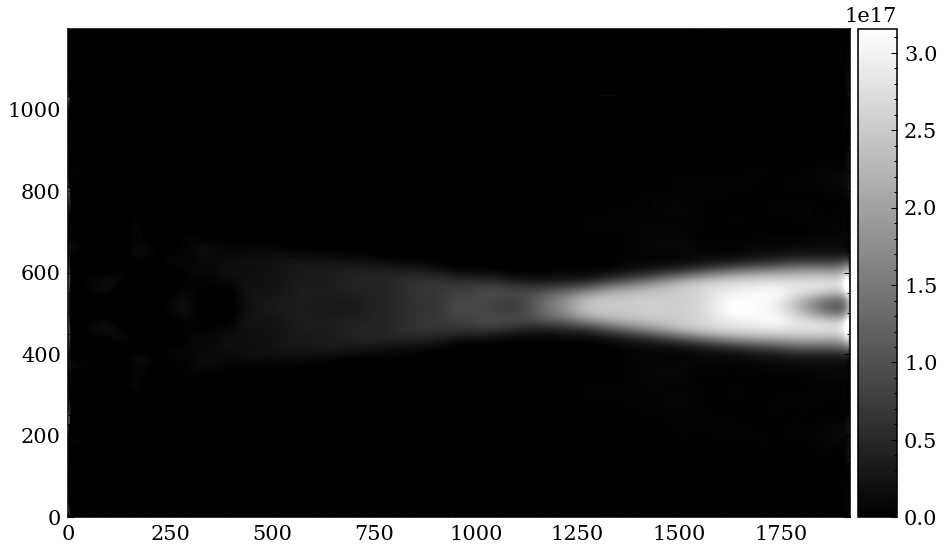

In [25]:
from interferometry import get_density
density = get_density(pha, M=3.17, symmetric=True)
colorbar(plt.imshow(density.value,vmin=density[valid].min().value, vmax=min(density[valid].max().value, 1.5e19)))

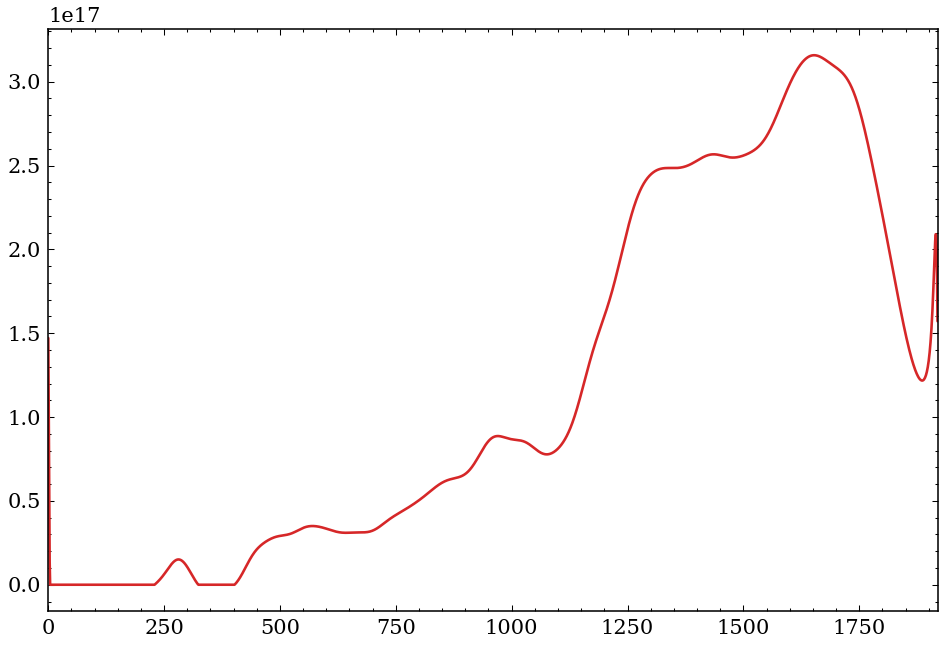

In [26]:
plt.plot(density.value[center])

In [10]:
pha_sym = np.mean((pha, np.roll(np.flipud(pha),-2 * abs(h//2 - center) + 1, axis=0)), axis=0)

colorbar(plt.imshow(cv2.GaussianBlur(pha_sym, (75,75),0), vmin=vmin, vmax=vmax))

NameError: name 'h' is not defined

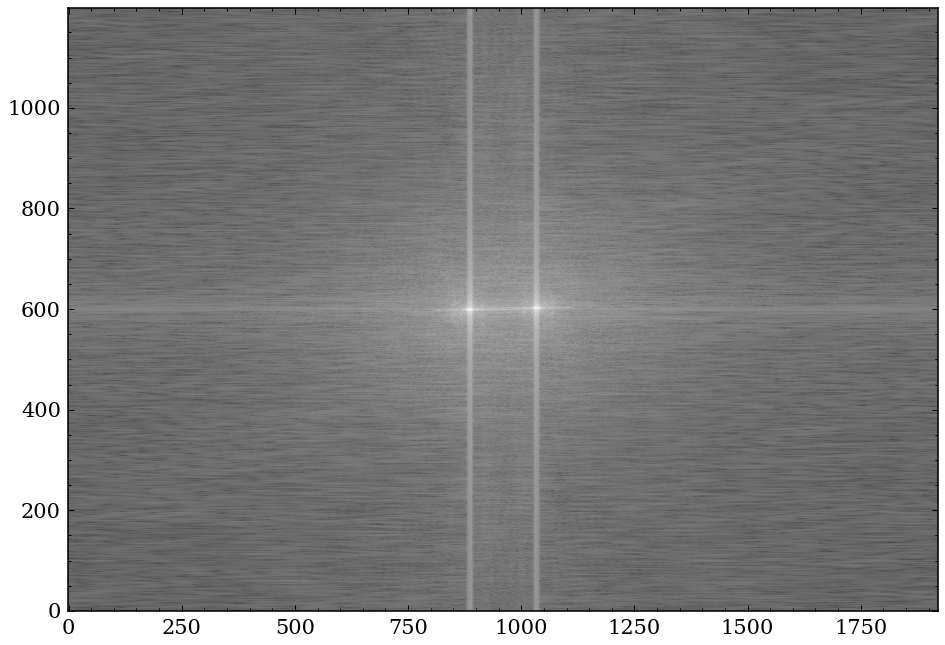

In [197]:
window = 1. #np.hanning(data.shape[0])[:,None] * np.hanning(data.shape[1])[None,:]
#ref_fft = fftshift(fft2((refs[0] - refs[0].mean()) * window))
#ref_fft = fftshift(fft2(cv2.GaussianBlur(data - data.mean(), (9,9),0) * window ))#* exp(1j *pi*X/win_x + 1j*pi /win_y * Y)))
ref_fft = fftshift(fft2(data_eq * window ))#* exp(1j *pi*X/win_x + 1j*pi /win_y * Y)))

plt.imshow((log(abs(ref_fft))), aspect='auto')

In [198]:
k_cx, k_cy

(1030, 602)

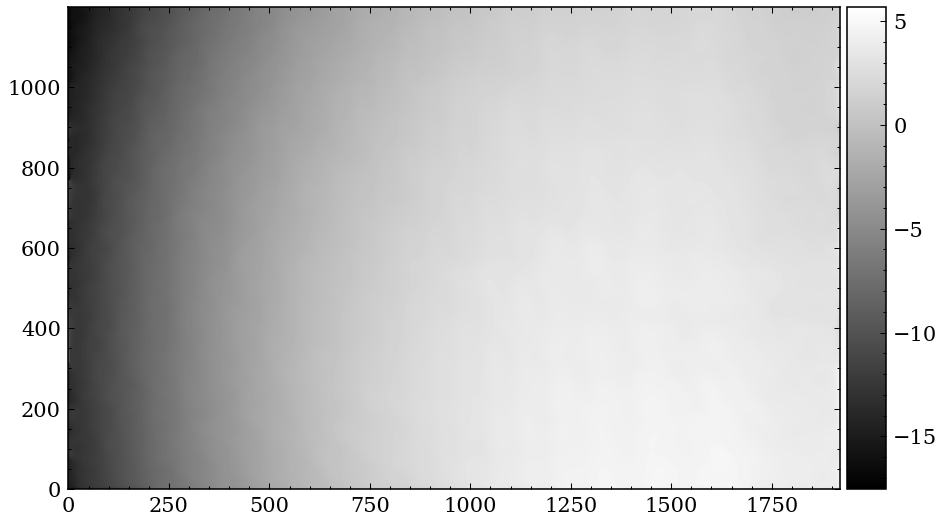

In [199]:
bw_x = 25
bw_y = 25
h, w = ref_fft.shape
dc = 5
ref_fft[h//2-dc :h//2+dc+1, w//2-dc:w//2+dc+1] = 0
k_cy, k_cx = np.unravel_index(np.argmax((abs((ref_fft)))), ref_fft.shape)
x, y = np.arange(w), np.arange(h)
X, Y = np.meshgrid(x, y)
filter = exp(-((X - k_cx)**2/bw_x**2 + (Y-k_cy)**2/bw_y**2)/2)
#plt.imshow(filter, aspect='auto')
#plt.show()

shifted_fft = (np.roll(np.roll(ref_fft*filter, -k_cx, axis=1),-k_cy, axis=0))

win_y = int(np.ceil( h / abs(h//2 - k_cy)/2.))
win_x = int(np.ceil( w / abs(w//2 - k_cx)/2.))

from skimage.restoration import unwrap_phase
pha = unwrap_phase((-log(ifft2(shifted_fft))/1j).real)
colorbar(plt.imshow(pha, ))

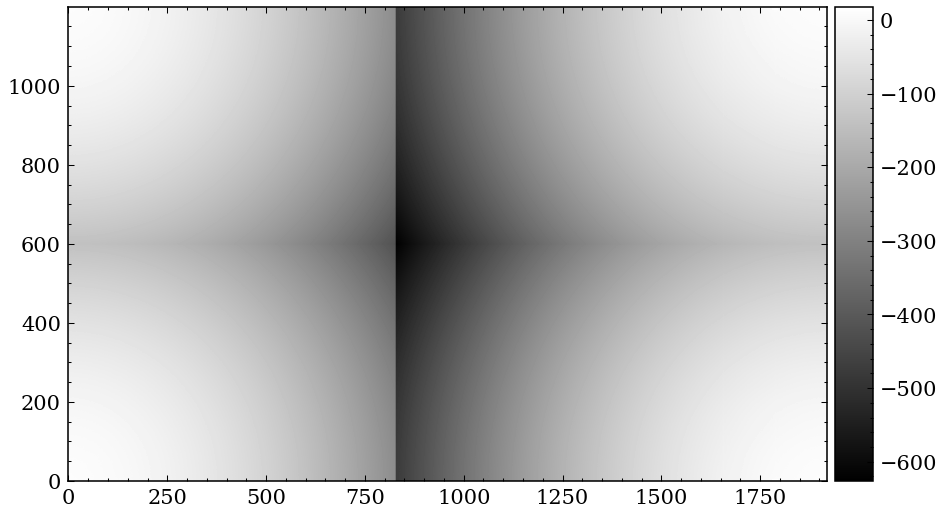

In [70]:
#shifted_fft = fftshift(ref_fft*filter)
'''if k_cx < w//2:
    shifted_fft[:,:w//2] = np.flip(shifted_fft[:,w//2:])
else:
    shifted_fft[:,w//2:] = np.flip(shifted_fft[:,:w//2])'''
colorbar(plt.imshow(log(abs(shifted_fft)),))

In [200]:
plt.imshow(exp(1j *pi*X/win_x + 1j*pi /win_y * Y).real)

In [206]:
#filter = np.zeros(ref_fft.shape)


#filter[h//2 - win_y:h//2+win_y, w//2 - win_x:w//2+win_x] = 1.
#plt.imshow(filter)
#plt.show()
#filter = fftshift(fft2(filter*exp(1j *pi*X/win_x + 1j*pi /win_y * Y)))
#colorbar(plt.imshow((abs(filter)), ))

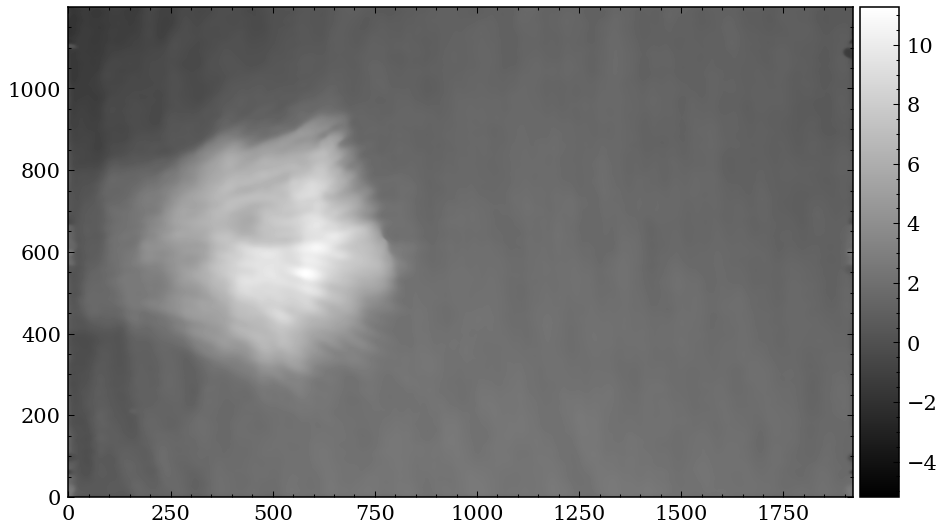

In [201]:
plt.imshow(exp(1j *pi*X/win_x + 1j*pi /win_y * Y + 1j * pha).real)

In [7]:
def get_if_shot(shot_number, data_dir, realtime=False):
    date = int(data_dir.split('/202308')[1][:2])
    data_fname = glob.glob(data_dir + f'{shot_number}_Image*.tiff')[0]
    try:
        print(f'Data File: = {data_fname}')
    except:
        print(f"No file found for shot {shot_number}!")
        return None, None
    
    data = np.array(Image.open(data_fname), dtype=float)
    ref_dir = data_dir + 'background/'
    # from august 10th onwards, we saved reference *before* taking shots for easier real time processing
    early_ref = date >= 10
    if early_ref and realtime:
        # Grab the latest file in the reference directory
        files = glob.glob(ref_dir+'*.tiff')
        ref_fname = max(files, key=os.path.getmtime)
    elif early_ref and not realtime:
        # Grab the latest file created before the data file
        files = glob.glob(ref_dir + '*.tiff')
        files.sort(key = lambda x: os.path.getmtime(x))
        print(os.path.getmtime(data_dir + data_fname))
        ref_fname = files[-1]
        for i, fname in enumerate(files):
            if os.path.getmtime(fname) > os.path.getmtime(data_dir + data_fname):
                ref_fname = files[i-1]
                break
        
    elif date == 9:
        # Reference is less organized this day, pull specific files for ranges of shots
        if shot_number < 8:
            ref_fname = 'Image__2023-08-09__15-42-47.tiff'
        elif shot_number < 27:
            ref_fname = 'Image__2023-08-09__17-04-23.tiff'
        elif shot_number < 30:
            ref_fname = 'Image__2023-08-09__17-20-20.tiff'
        elif shot_number < 45:
            ref_fname = 'Image__2023-08-09__17-47-40.tiff'
        elif shot_number < 47:
            ref_fname = 'Image__2023-08-09__18-20-16.tiff'
        elif shot_number < 49:
            ref_fname = 'Image__2023-08-09__18-30-46.tiff'
        elif shot_number < 53:
            ref_fname = 'Image__2023-08-09__18-31-17.tiff'
        else:
            ref_fname = 'Image__2023-08-09__18-36-54.tiff'
        ref_fname = ref_dir + ref_fname
    else:
        files = os.listdir(ref_dir)
        if date == 3:
            ref_fname = ref_dir + "with_gas_Image__2023-08-03__18-51-55.tiff"
        else:
            shot_timestamp = data_fname.split('.tiff')[0][-8:]

            shot_time = int(shot_timestamp[:2]) * 60 + int(shot_timestamp[3:5])
            timestamps = []
            for fname in files:
                if (date == '0804' and 'no_regen' in fname):
                    shot_timestamp = fname.split('.tiff')[0][-8:]
                    shot_time = int(shot_timestamp[:2]) * 60 + int(shot_timestamp[3:5])
                else:
                    shot_time = 0
                timestamps.append(shot_time)
            ref_fname = ref_dir + files[np.argmin(np.array(timestamps) - shot_time)]
        
    ref = np.array(Image.open( ref_fname), dtype=float)
    print(f'Reference File: = {ref_fname}')
    
    return data, ref

In [142]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

X, Y = np.meshgrid(x, y, copy=False)


# Process 2D inputs
poly = PolynomialFeatures(degree=21)
input_pts = np.stack([X.flatten(), Y.flatten()]).T
#assert(input_pts.shape == (400, 2))
in_features = poly.fit_transform(input_pts)

# Linear regression
model = LinearRegression(fit_intercept=False)
model.fit(in_features, pha.flatten())

# Display coefficients
print(dict(zip(poly.get_feature_names_out(), model.coef_.round(4))))

# Check fit
print(f"R-squared: {model.score(poly.transform(input_pts), pha.flatten()):.3f}")

# Make predictions
Z_predicted = model.predict(poly.transform(input_pts))

{'1': 0.0, 'x0': 0.0, 'x1': -0.0, 'x0^2': 0.0, 'x0 x1': -0.0, 'x1^2': 0.0, 'x0^3': 0.0, 'x0^2 x1': 0.0, 'x0 x1^2': -0.0, 'x1^3': 0.0, 'x0^4': -0.0, 'x0^3 x1': -0.0, 'x0^2 x1^2': 0.0, 'x0 x1^3': -0.0, 'x1^4': -0.0, 'x0^5': 0.0, 'x0^4 x1': 0.0, 'x0^3 x1^2': -0.0, 'x0^2 x1^3': 0.0, 'x0 x1^4': -0.0, 'x1^5': -0.0, 'x0^6': -0.0, 'x0^5 x1': 0.0, 'x0^4 x1^2': -0.0, 'x0^3 x1^3': 0.0, 'x0^2 x1^4': -0.0, 'x0 x1^5': 0.0, 'x1^6': -0.0, 'x0^7': 0.0, 'x0^6 x1': -0.0, 'x0^5 x1^2': -0.0, 'x0^4 x1^3': 0.0, 'x0^3 x1^4': 0.0, 'x0^2 x1^5': -0.0, 'x0 x1^6': -0.0, 'x1^7': -0.0, 'x0^8': 0.0, 'x0^7 x1': 0.0, 'x0^6 x1^2': 0.0, 'x0^5 x1^3': 0.0, 'x0^4 x1^4': 0.0, 'x0^3 x1^5': 0.0, 'x0^2 x1^6': 0.0, 'x0 x1^7': -0.0, 'x1^8': -0.0, 'x0^9': 0.0, 'x0^8 x1': 0.0, 'x0^7 x1^2': 0.0, 'x0^6 x1^3': -0.0, 'x0^5 x1^4': -0.0, 'x0^4 x1^5': -0.0, 'x0^3 x1^6': 0.0, 'x0^2 x1^7': -0.0, 'x0 x1^8': -0.0, 'x1^9': -0.0, 'x0^10': 0.0, 'x0^9 x1': 0.0, 'x0^8 x1^2': -0.0, 'x0^7 x1^3': -0.0, 'x0^6 x1^4': 0.0, 'x0^5 x1^5': 0.0, 'x0^4 x1^6':

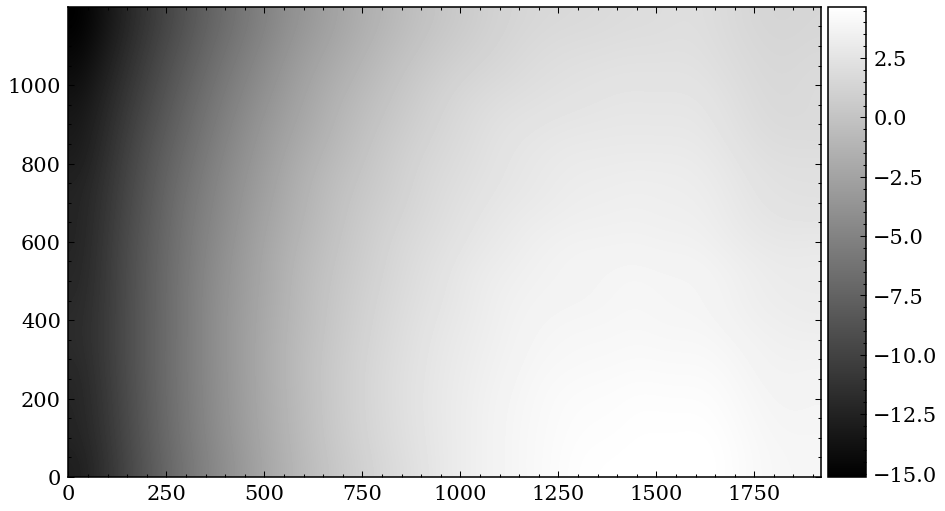

In [202]:
blur = cv2.GaussianBlur(pha, (355,355),0)
colorbar(plt.imshow(blur))

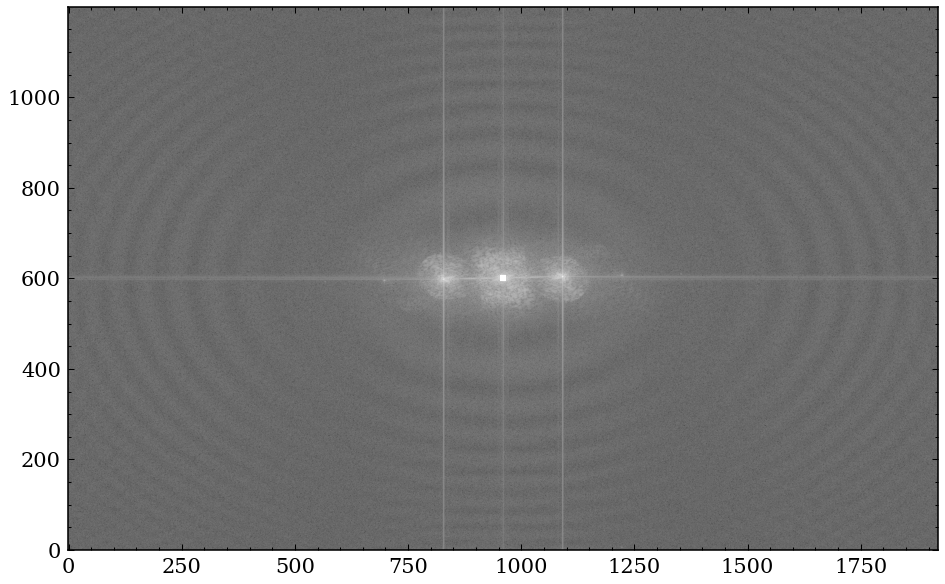

In [156]:
plt.imshow(log(abs(ref_fft)))

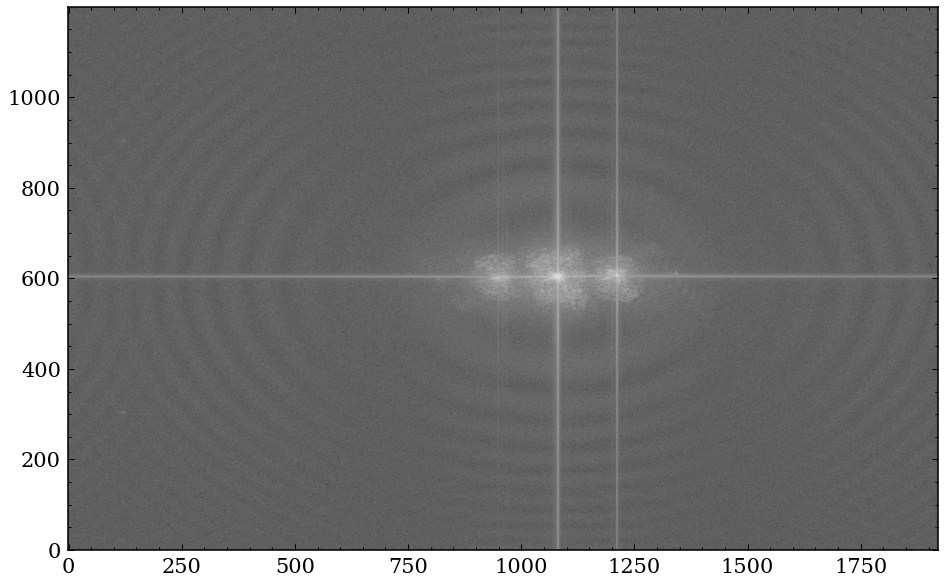

In [161]:
fft_2 = fftshift(fft2(data*exp(1j *pi*X/win_x + 1j*pi /win_y * Y + 1j * blur)))
plt.imshow(log(abs(fft_2)))

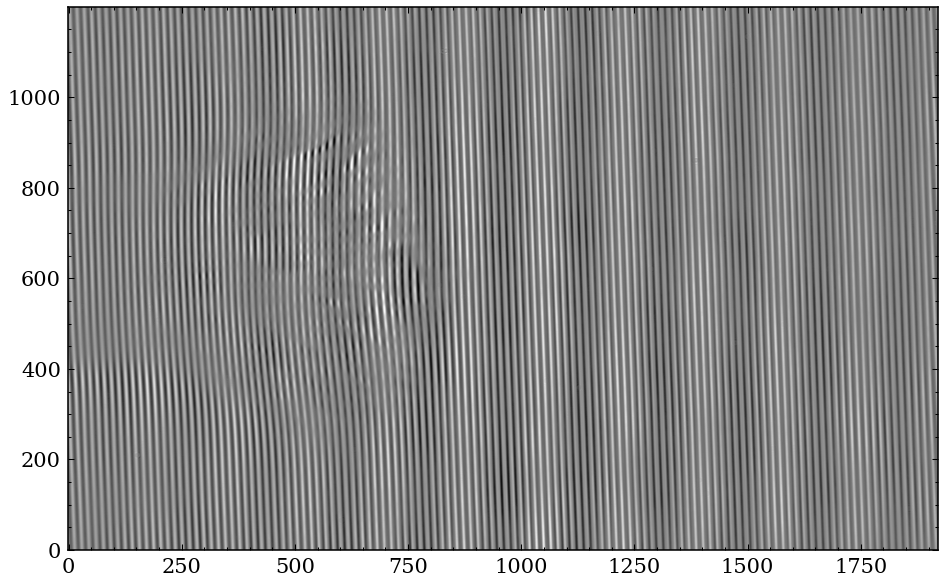

In [163]:
plt.imshow(ifft2(ifftshift(fft_2)).real)